In [1]:
from dataclasses import dataclass
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from functools import partial
import jax
import jax.numpy as jnp
import flax
from flax import nnx
import optax

from json import loads

key = jax.random.PRNGKey(0) 


In [2]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

## Sonnleiter ODE

In [3]:
@dataclass
class Params:
    """ Parameter for Sonnleiter ODE"""
    ks:float
    ke:float
    ko:float
    Ks:float
    Ke:float
    Ko:float
    Ki:float
    a1:float
    a3:float
    b1:float
    b2:float
    b3:float
    Sin:float
    Ein:float
    O2in:float
    d2:float
    kla:float
    O2star:float

@dataclass
class Input:
    u:list
    t:list

In [4]:
def sonnleitner_ode(t:float, x:jax.Array, p:Params, u:Input) -> jax.Array:
    """ ODE to describe yeast fermentation process using Sonnleitner model.
    
    Parameters:
        t (float): Time.
        x (jax.Array): State vector [B, S, E, O2].
        p (object): Object containing model parameters with attributes 
                    ks, Ke, Ko, Ki, a1, a3, b1, b2, b3, Sin, Ein, O2in, kla, O2star.
        u (object): Object containing input function (u.u) and time vector (u.t).

    Returns:
        np.ndarray: Right-hand side of model equations [Bdot, Sdot, Edot, O2dot].
    """

    B, S, E, O2 = x

    # Sonnleitner model
    rs = p.ks * S / (S + p.Ks)
    re = p.ke * E / (E + p.Ke)
    ro = p.ko * O2 / (O2 + p.Ko) * (p.Ki / (p.Ki + E))

    r1 = min(rs, ro / p.a1)
    r2 = max(0, rs - ro / p.a1)
    r3 = max(0, min(re, (ro - p.a1 * rs) / p.a3))

    # Dilution rate
    D = interp1d(u.t, u.u, fill_value="extrapolate")(t)

    # Balance equations
    Bdot = -D * B + (p.b1 * r1 + p.b2 * r2 + p.b3 * r3) * B
    Sdot = D * (p.Sin - S) - (r1 + r2) * B
    Edot = D * (p.Ein - E) + (p.d2 * r2 - r3) * B
    O2dot = D * (p.O2in - O2) + p.kla * (p.O2star - O2) - (p.a1 * r1 + p.a3 * r3) * B

    return jnp.array([Bdot, Sdot, Edot, O2dot])


In [5]:
def stepfun(t, step_time):
    """Step function for generating piecewise input signals."""
    return jnp.heaviside(t - step_time, 1)

p = Params(**loads(open("/home/matthias/WS_all/dbm/raw/ex6_handout/params.json","r").read()))

t = jnp.linspace(0, 50, 1001)
u1 = Input(
    t=t,
    u=0.7 - 0.2 * stepfun(t, 5) - 0.4 * stepfun(t, 10) + 0.7 * stepfun(t, 17)
        - 0.1 * stepfun(t, 23) - 0.1 * stepfun(t, 25) - 0.4 * stepfun(t, 30)
        + 0.4 * stepfun(t, 35) + 0.2 * stepfun(t, 42) - 0.5 * stepfun(t, 46)
)

x0l = jnp.array([0.0, 0.0, 0.0, 0.0])
x0u = jnp.array([10.0, 1.0, 5.0, 1e-2])
dimx = len(x0l)
x0 = x0l + jnp.diag(x0u - x0l) @ jax.random.uniform(key, shape=(dimx,))

sol1 = solve_ivp(
    lambda t, x: sonnleitner_ode(t, x, p, u1),
    t_span=(t[0], t[-1]),
    y0=x0,
    t_eval=t
)

tsim1, x1 = sol1.t, sol1.y.T

y_train = jnp.array(x1[:, 0])
u_train = jnp.array(u1.u)


u2 = Input(
    t=t,
    u=0.1 - 0.1 * stepfun(t, 6) + 0.2 * stepfun(t, 12) + 0.5 * stepfun(t, 14)
        + 0.1 * stepfun(t, 20) - 0.6 * stepfun(t, 26) - 0.1 * stepfun(t, 30)
        + 0.5 * stepfun(t, 35) - 0.5 * stepfun(t, 39) + 0.2 * stepfun(t, 42)
)

x0 = x0l + jnp.diag(x0u - x0l) @ jnp.array([0.5, 0.6, 0.0, 0.4])

sol2 = solve_ivp(
    lambda t, x: sonnleitner_ode(t, x, p, u2),
    t_span=(t[0], t[-1]),
    y0=x0,
    t_eval=t
)

tsim2, x2 = sol2.t, sol2.y.T

y_test = jnp.array(x2[:, 0])
u_test = jnp.array(u2.u)

Ts = jnp.mean(jnp.diff(t))


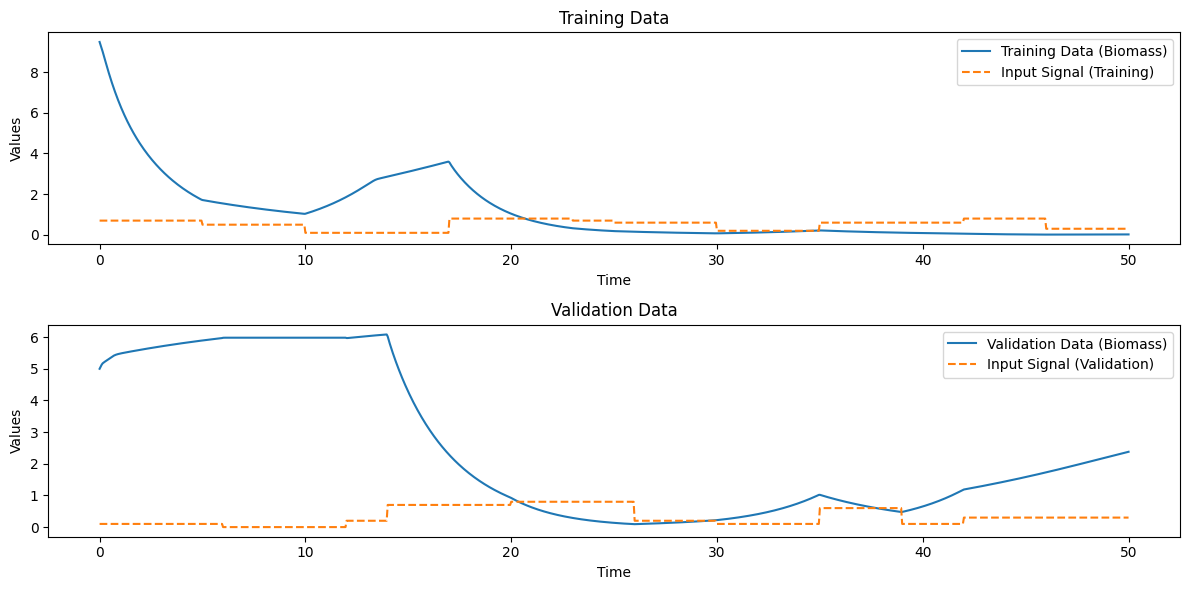

In [6]:
plt.figure(figsize=(12, 6))

# Training data
plt.subplot(2, 1, 1)
plt.plot(tsim1, y_train, label="Training Data (Biomass)")
plt.plot(tsim1, u_train, label="Input Signal (Training)", linestyle='--')
plt.legend()
plt.title("Training Data")
plt.xlabel("Time")
plt.ylabel("Values")

# Validation data
plt.subplot(2, 1, 2)
plt.plot(tsim2, y_test, label="Validation Data (Biomass)")
plt.plot(tsim2, u_test, label="Input Signal (Validation)", linestyle='--')
plt.legend()
plt.title("Validation Data")
plt.xlabel("Time")
plt.ylabel("Values")

plt.tight_layout()
plt.show()


# Data Augmentation


In [7]:
ytrain = y_train.reshape(-1,1)
ytest = y_test.reshape(-1,1)
ytrain = ytrain[:-1]

WIN = 10

In [8]:
def arrange_data(u,y, window = 5):
    x = []
    y = y.flatten()
    
    for i in range(1,u.shape[0]):
        if i < window:
            y_ = y[0:i]
            y_ = jnp.pad(y_, (window - i, 0), mode='constant', constant_values=-1)
        else:
            y_ = y[i - window:i]
        
        assert len(y_) == window, f"Expected window size {window}, got {len(y_)} on iteration {i}"
        data = jnp.concatenate([y_, jnp.array([u[i]])])
        assert len(data) == window + 1, f"Expected data size {window + 1}, got {len(data)} on iteration {i}"
        x.append(data)

    return jnp.array(x)

x = arrange_data(u_train,ytrain, window = WIN)
x.shape

x[:10]

Array([[-1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       , -1.       ,  9.47667  ,
         0.7      ],
       [-1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       , -1.       ,  9.47667  ,  9.320561 ,
         0.7      ],
       [-1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       , -1.       ,  9.47667  ,  9.320561 ,  9.16171  ,
         0.7      ],
       [-1.       , -1.       , -1.       , -1.       , -1.       ,
        -1.       ,  9.47667  ,  9.320561 ,  9.16171  ,  8.997469 ,
         0.7      ],
       [-1.       , -1.       , -1.       , -1.       , -1.       ,
         9.47667  ,  9.320561 ,  9.16171  ,  8.997469 ,  8.825305 ,
         0.7      ],
       [-1.       , -1.       , -1.       , -1.       ,  9.47667  ,
         9.320561 ,  9.16171  ,  8.997469 ,  8.825305 ,  8.646367 ,
         0.7      ],
       [-1.       , -1.       , -1.       ,  9.47667  ,  9

In [9]:
def simulate(model, u, y0, window=5):
    """Simulate the model using autoregressive prediction with history.

    Args:
        model (nnx.Module): The model to simulate.
        u (jax.Array): Input sequence (shape [T, ...]).
        y0 (float): Initial output value.
        window (int): Number of past outputs to include.

    Returns:
        jax.Array: Predicted outputs.
    """
    y_pred = [y0]

    for t in range(1, u.shape[0]):
        # Build rolling window of past predictions (pad if needed)
        if t < window:
            past = jnp.pad(jnp.array(y_pred), (window - t, 0), constant_values=-1)
        else:
            past = jnp.array(y_pred[-window:])
        
        # Construct model input: [y_{t-k}, ..., y_{t-1}, u_t]
        inp = jnp.concatenate([past, jnp.array([u[t]])])
        y_t = model(inp).flatten()[0]
        y_pred.append(y_t)

    return jnp.array(y_pred[1:])  # skip initial y0

In [10]:
class Model(nnx.Module):
  def __init__(self, din, dmid, dout, rngs: nnx.Rngs):
    self.linear_in = nnx.Linear(din, dmid, rngs=rngs)
    self.linear1 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear2 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear3 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear4 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear5 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear6 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear7 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear8 = nnx.Linear(dmid, dmid, rngs=rngs)
    self.linear_out = nnx.Linear(dmid, dout, rngs=rngs)
  
  def __call__(self, x):
    x = nnx.relu(self.linear_in(x))
    x = nnx.relu(self.linear1(x))
    x = nnx.relu(self.linear2(x))
    x = nnx.relu(self.linear3(x))
    x = nnx.relu(self.linear4(x))
    x = nnx.relu(self.linear5(x))
    x = nnx.relu(self.linear6(x))
    x = nnx.relu(self.linear7(x))
    x = nnx.relu(self.linear8(x))
    x = self.linear_out(x)
    return x


def rollout_loss(model, u, y_true, y0, window):
    y_pred = simulate(model, u, y0, window=window)
    return jnp.mean(jnp.abs(y_pred - y_true[1:]))  # exclude y0

def mean_absolute_error(y_true, y_pred):
    return jnp.mean(jnp.abs(y_true - y_pred))

@partial(nnx.jit, static_argnames = ("loss_func",)) 
def train_step(model:nnx.Module, optimizer:nnx.Optimizer, x:jax.Array, y:jax.Array, loss_func = mean_absolute_error):
  """ Train step for the model.
  
  Args:
    model (nnx.Module): Model to train.
    optimizer (nnx.Optimizer): Optimizer to use.
    x (jax.Array): Input data.
    y (jax.Array): Target data.

  Returns:
    jax.Array: Loss value.
  """
  def loss_fn(model:nnx.Module):
    y_pred = model(x)  # call methods directly
    return loss_func(y, y_pred)

  loss, grads = nnx.value_and_grad(loss_fn)(model)
  optimizer.update(grads)  # in-place updates

  return loss


def train(model, optimizer, x,y, epochs):
  """ Train the model.
  
  Args:
    model (nnx.Module): Model to train.
    optimizer (nnx.Optimizer): Optimizer to use.
    dataset (tuple): Tuple containing input and target data.
    epochs (int): Number of epochs to train.

  Returns:
    list: List of loss values.
  """
  history = jnp.zeros(epochs)

  for epoch in range(epochs):
    loss = train_step(model, optimizer, x, y)
    
    if epoch % 100 == 0:
      print(f"Epoch {epoch}, Loss {loss}")
    history = history.at[epoch].set(loss)
    
  return model, history

In [11]:
rngs = nnx.Rngs(0)

model = Model(1+WIN, 48, 1, rngs)  
optimizer = nnx.Optimizer(model, optax.adamw(1e-6,weight_decay=1e-4))  

In [23]:
model,history = train(model, optimizer, x, ytrain, 15000)

Epoch 0, Loss 0.0023701966274529696
Epoch 100, Loss 0.0023414085153490305
Epoch 200, Loss 0.00232497975230217
Epoch 300, Loss 0.0023158735129982233
Epoch 400, Loss 0.00230597285553813
Epoch 500, Loss 0.002296281512826681
Epoch 600, Loss 0.0022926211822777987
Epoch 700, Loss 0.0022786478511989117
Epoch 800, Loss 0.0022703350987285376
Epoch 900, Loss 0.0022642784751951694
Epoch 1000, Loss 0.002253399696201086
Epoch 1100, Loss 0.0022446855437010527
Epoch 1200, Loss 0.002236102009192109
Epoch 1300, Loss 0.002228262135758996
Epoch 1400, Loss 0.002220510272309184
Epoch 1500, Loss 0.0022125120740383863
Epoch 1600, Loss 0.00220551248639822
Epoch 1700, Loss 0.002195497276261449
Epoch 1800, Loss 0.002188559854403138
Epoch 1900, Loss 0.0021793420892208815
Epoch 2000, Loss 0.002170413266867399
Epoch 2100, Loss 0.002167825121432543
Epoch 2200, Loss 0.0021566860377788544
Epoch 2300, Loss 0.002149416832253337
Epoch 2400, Loss 0.002139023505151272
Epoch 2500, Loss 0.002130744280293584
Epoch 2600, Loss

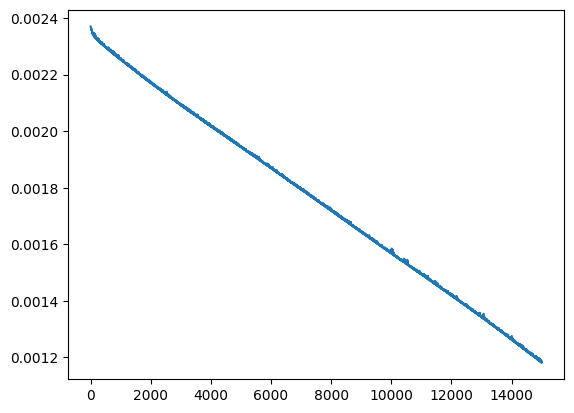

In [24]:
plt.plot(history)
plt.show()

In [25]:

y_pred = simulate(model, u_test, ytest[0][0],WIN)
y_pred_train = simulate(model, u_train, ytrain[0][0],WIN)


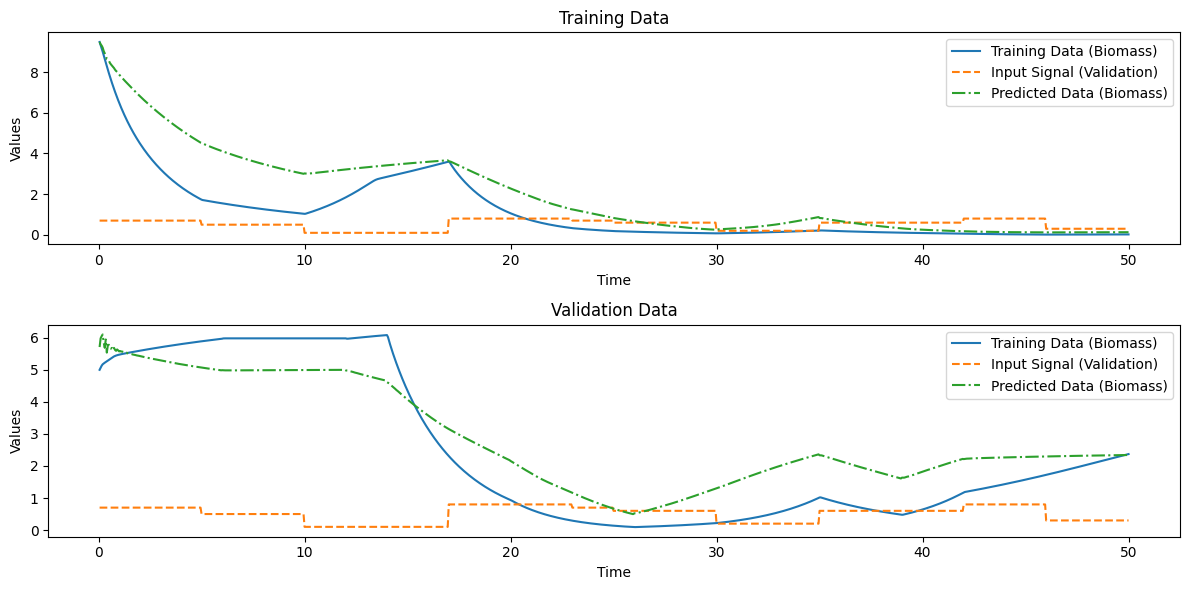

In [26]:
# For now, let's plot the data as a visual verification
plt.figure(figsize=(12, 6))

# Validation data
plt.subplot(2, 1, 2)
plt.plot(tsim2[1:], ytest[:-1], label="Training Data (Biomass)")
plt.plot(tsim2[1:], u_train[1:], label="Input Signal (Validation)", linestyle='--')
plt.plot(tsim2[1:], y_pred, label="Predicted Data (Biomass)", linestyle='-.')
plt.legend()
plt.title("Validation Data")
plt.xlabel("Time")
plt.ylabel("Values")

#Training Data
plt.subplot(2, 1, 1)
plt.plot(tsim2[1:], ytrain, label="Training Data (Biomass)")
plt.plot(tsim2[1:], u_train[1:], label="Input Signal (Validation)", linestyle='--')
plt.plot(tsim2[1:], y_pred_train, label="Predicted Data (Biomass)", linestyle='-.')
plt.legend()
plt.title("Training Data")
plt.xlabel("Time")
plt.ylabel("Values")

plt.tight_layout()
plt.show()
